# World Navigation with DQRN

This is using most of the codes from DQN to build a Deep Q Recurrent Network. There are three differences to DQN:
- After the last CONV layer, a LSTM is added to capture temporal information.
- We instead of sample the whole experience, we sample part of an experience with a fixed length.
- In passing gradient, we mask away the first half of the gradient since they are not as useful.

Reference: [Medium post](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-6-partial-observability-and-deep-recurrent-q-68463e9aeefc)

In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

### Load the game environment
Notice we have `partial=True`, which means the agent can only see a local region around it isntead of the whole field.

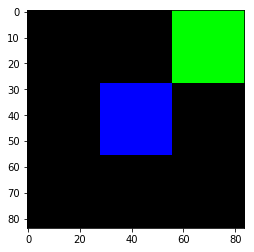

In [2]:
from gridworld import gameEnv

env = gameEnv(partial=True,size=5)

## Experience Buffer
We sample parts of experiences with fixed length now.

In [3]:
class experience_buffer():
    def __init__(self, buffer_size = 1000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
            
    def sample(self,batch_size,trace_length):
        sampled_episodes = random.sample(self.buffer,batch_size)
        sampledTraces = []
        for episode in sampled_episodes:
            point = np.random.randint(0,len(episode)+1-trace_length)
            sampledTraces.append(episode[point:point+trace_length])
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces,[batch_size*trace_length,5])

This is a simple function to resize our game frames:

Modification: added `/255.0` otherwise network might explode.

In [4]:
def processState(states):
    return np.reshape(states,[21168]) / 255.0 # 84 x 84 x 3

These functions allow us to update the parameters of our target network with those of the primary network.

In [5]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

### Implementing the network itself
Modification: Added LSTM, masked gradient

In [6]:
class Qnetwork():
    def __init__(self,h_size,lstm_cell,scope):
        with tf.variable_scope(scope):
            #The network recieves a frame from the game, flattened into an array.
            #It then resizes it and processes it through four convolutional layers.
            #We use slim.conv2d to set up our network 
            self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
            self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
            self.conv1 = slim.conv2d( \
                inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
            self.conv2 = slim.conv2d( \
                inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
            self.conv3 = slim.conv2d( \
                inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
            self.conv4 = slim.conv2d( \
                inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)

            
            self.lstm_input_size = tf.placeholder(shape=[], dtype=tf.int32)
            self.batch_size = tf.placeholder(shape=[], dtype=tf.int32)
            self.lstm_state_in = lstm_cell.zero_state(self.batch_size, tf.float32)
            
            flat = tf.layers.flatten(self.conv4)
            flat = tf.reshape(flat, (self.batch_size, self.lstm_input_size, h_size))
            self.lstm, self.lstm_state = tf.nn.dynamic_rnn(inputs=flat,
                                                            cell=lstm_cell,
                                                            dtype=tf.float32,
                                                            initial_state=self.lstm_state_in)
            self.lstm = tf.reshape(self.lstm, shape=[-1, h_size])

            ################################################################################
            # TODO: Implement Dueling DQN                                                  #
            # We take the output from the final convolutional layer i.e. self.conv4 and    #
            # split it into separate advantage and value streams.                          #
            # Outout: self.Advantage, self.Value                                           #
            # Hint: Refer to Fig.1 in [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf)  #
            #       In implementation, use tf.split to split into two branches. You may    #
            #       use xavier_initializer for initializing the two additional linear      #
            #       layers.                                                                # 
            ################################################################################
            adv, val = tf.split(self.lstm, 2, 1)
            self.Advantage = tf.layers.dense(slim.flatten(adv), env.actions)
            self.Value = tf.layers.dense(slim.flatten(val), 1)
            ################################################################################
            #                                 END OF YOUR CODE                             #
            ################################################################################

            #Then combine them together to get our final Q-values. 
            #Please refer to Equation (9) in [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf)
            self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
            self.predict = tf.argmax(self.Qout,1)

            #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
            self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)

            ################################################################################
            # TODO:                                                                        #
            # Obtain the loss (self.loss) by taking the sum of squares difference          #
            # between the target and prediction Q values.                                  #
            ################################################################################
            predictQ = tf.reduce_sum(self.Qout*self.actions_onehot,axis = 1)

            # Lample & Chatlot 2016
            mask = tf.concat([tf.zeros([self.batch_size, self.lstm_input_size//2]),
                                   tf.ones([self.batch_size, self.lstm_input_size//2])],1)
            mask = tf.reshape(mask, [-1])

            self.loss = tf.reduce_mean((predictQ - self.targetQ)**2 * mask)
            ################################################################################
            #                                 END OF YOUR CODE                             #
            ################################################################################

            self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
            self.updateModel = self.trainer.minimize(self.loss)

### Training the network

Setting all the training parameters

Modification:
- Added trace_length
- In each epsiode, LSTM states are recycled.
- After each episode, LSTM states are reset to 0 and the data of the whole episode is used to do back prop.
- States are reset to 0 again after back prop for new episode.

In [7]:
batch_size = 4 #How many experience traces to use for each training step.
trace_length = 8 #How long each experience trace will be when training
update_freq = 5 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [8]:
tf.reset_default_graph()

cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
mainQN = Qnetwork(h_size,cell,'main')
targetQN = Qnetwork(h_size,cellT,'target')

init = tf.global_variables_initializer()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

with tf.Session() as sess:

    sess.run(init)
   #updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        state = (np.zeros([1, h_size]), np.zeros([1, h_size]))
        #The Q-Network
        while j < max_epLength: 
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                state = sess.run(mainQN.lstm_state, feed_dict={mainQN.scalarInput: [s],
                                                              mainQN.lstm_input_size: 1,
                                                              mainQN.lstm_state_in: state,
                                                              mainQN.batch_size: 1})
                a = np.random.randint(0,4)
            else:
                a, state = sess.run([mainQN.predict, mainQN.lstm_state], feed_dict={mainQN.scalarInput: [s],
                                                                                   mainQN.lstm_input_size: 1,
                                                                                   mainQN.lstm_state_in: state,
                                                                                   mainQN.batch_size: 1})
                a = a[0]
            total_steps += 1
            
            ###############################################################################
            # TODO: Save the experience to our episode buffer.                             #
            # You will need to do the following:                                           #
            # (1) Get new state s1 (resized), reward r and done d from a                   #
            # (2) Add experience to episode buffer. Hint: experience includes              #
            #     s, a, r, s1 and d.                                                       #
            ################################################################################
            s1, r, d = env.step(a)
            s1 = processState(s1)
            experience = np.expand_dims(np.array([s, a, r, s1, d]), 0)
            episodeBuffer.add(experience)   
            ################################################################################
            #                                 END OF YOUR CODE                             #
            ################################################################################
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop

                if total_steps % (update_freq) == 0:
                    
                    ################################################################################
                    # TODO: Implement Double-DQN                                                   #
                    # (1) Get a random batch of experiences via experience_buffer class            #
                    #                                                                              #
                    # (2) Perform the Double-DQN update to the target Q-values                     #
                    #     Hint: Use mainQN and targetQN separately to chose an action and predict  #
                    #     the Q-values for that action.                                            #
                    #     Then compute targetQ based on Double-DQN equation                        #
                    #                                                                              #
                    # (3) Update the primary network with our target values                        #
                    ################################################################################ 
                    initial_state = (np.zeros([batch_size,h_size]), np.zeros([batch_size,h_size])) 
                    
                    batch = myBuffer.sample(batch_size, trace_length)
                    stacked_state = np.vstack(batch[:, 3])

                    action_ = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput: stacked_state,
                                                                  mainQN.lstm_input_size: trace_length,
                                                                  mainQN.lstm_state_in: initial_state,
                                                                  mainQN.batch_size: batch_size})
                    Q_ = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput: stacked_state,
                                                           targetQN.lstm_input_size: trace_length,
                                                           targetQN.lstm_state_in: initial_state,
                                                           targetQN.batch_size: batch_size})
                    next_Q = Q_[range(batch_size*trace_length), action_]
                    done_mask = 1 - batch[:, 4]
                    targetQ = batch[:, 2] + done_mask * y * next_Q
                    
                    sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput: np.vstack(batch[:,0]),
                                                            mainQN.targetQ: targetQ,
                                                            mainQN.actions: batch[:,1],
                                                            mainQN.lstm_input_size:trace_length,
                                                            mainQN.lstm_state_in: initial_state,
                                                            mainQN.batch_size: batch_size})
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.

            rAll += r
            s = s1
            if d == True:

                break

        #Add the episode to the experience buffer
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        if len(rList) % 10 == 0:
            print("Episode",i,"reward:",np.mean(rList[-10:]))
print("Mean reward per episode: " + str(sum(rList)/num_episodes))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Episode 9 reward: 3.1
Episode 19 reward: 2.6
Episode 29 reward: 3.2
Episode 39 reward: 2.1
Episode 49 reward: 1.5
Episode 59 reward: 1.8
Episode 69 reward: 2.9
Episode 79 reward: 2.1
Episode 89 reward: 1.8
Episode 99 reward: 1.8
Episode 109 reward: 3.5
Episode 119 reward: 1.2
Episode 129 reward: 0.6
Episode 139 reward: 2.5
Episode 149 reward: 2.6
Episode 159 reward: -0.3
Episode 169 reward: 2.7
Episode 179 reward: 1.4
Episode 189 reward: 1.4
Episode 199 reward: 1.5
Episode 209 reward: 2.4
Episode 219 reward: 2.6
Episode 229 reward: 4.6
Episode 239 reward: 2.9
Episode 249 reward: 5.5
Episode 259 reward: 4.4
Episode 269 reward: 2.7
Episode 279 reward: 4.9
Episode 289 reward: 6.5
Episode 299 reward: 5.5
Episode 309 reward: 5.0
Episode 319 reward: 5.0
Episode 329 reward: 8.7
Episode 339 reward: 5.5
Episode 349 reward: 6.2
Episode 359 reward: 6.8
Episode 369 reward: 6.3
Episode 379 reward: 7.5
Episode 389 reward: 7.0
E

Episode 3119 reward: 21.4
Episode 3129 reward: 19.8
Episode 3139 reward: 19.8
Episode 3149 reward: 19.7
Episode 3159 reward: 19.7
Episode 3169 reward: 21.2
Episode 3179 reward: 20.7
Episode 3189 reward: 19.6
Episode 3199 reward: 19.2
Episode 3209 reward: 21.6
Episode 3219 reward: 20.3
Episode 3229 reward: 20.1
Episode 3239 reward: 20.9
Episode 3249 reward: 20.3
Episode 3259 reward: 21.7
Episode 3269 reward: 20.8
Episode 3279 reward: 21.4
Episode 3289 reward: 20.0
Episode 3299 reward: 20.5
Episode 3309 reward: 17.9
Episode 3319 reward: 21.0
Episode 3329 reward: 19.6
Episode 3339 reward: 20.8
Episode 3349 reward: 21.5
Episode 3359 reward: 19.9
Episode 3369 reward: 18.4
Episode 3379 reward: 21.5
Episode 3389 reward: 21.8
Episode 3399 reward: 20.5
Episode 3409 reward: 21.9
Episode 3419 reward: 19.5
Episode 3429 reward: 20.6
Episode 3439 reward: 21.2
Episode 3449 reward: 20.9
Episode 3459 reward: 21.7
Episode 3469 reward: 21.0
Episode 3479 reward: 20.4
Episode 3489 reward: 20.5
Episode 3499

Episode 6279 reward: 21.2
Episode 6289 reward: 21.5
Episode 6299 reward: 20.8
Episode 6309 reward: 19.6
Episode 6319 reward: 21.3
Episode 6329 reward: 20.7
Episode 6339 reward: 19.6
Episode 6349 reward: 20.7
Episode 6359 reward: 21.6
Episode 6369 reward: 22.3
Episode 6379 reward: 20.6
Episode 6389 reward: 20.5
Episode 6399 reward: 21.7
Episode 6409 reward: 20.6
Episode 6419 reward: 20.0
Episode 6429 reward: 19.2
Episode 6439 reward: 20.0
Episode 6449 reward: 20.7
Episode 6459 reward: 22.7
Episode 6469 reward: 18.0
Episode 6479 reward: 20.3
Episode 6489 reward: 22.5
Episode 6499 reward: 19.2
Episode 6509 reward: 19.6
Episode 6519 reward: 20.5
Episode 6529 reward: 19.7
Episode 6539 reward: 23.4
Episode 6549 reward: 21.3
Episode 6559 reward: 19.9
Episode 6569 reward: 22.1
Episode 6579 reward: 20.1
Episode 6589 reward: 21.7
Episode 6599 reward: 21.2
Episode 6609 reward: 18.5
Episode 6619 reward: 20.8
Episode 6629 reward: 20.4
Episode 6639 reward: 20.6
Episode 6649 reward: 21.4
Episode 6659

Episode 9439 reward: 19.9
Episode 9449 reward: 19.8
Episode 9459 reward: 21.0
Episode 9469 reward: 19.7
Episode 9479 reward: 19.2
Episode 9489 reward: 21.1
Episode 9499 reward: 20.4
Episode 9509 reward: 19.6
Episode 9519 reward: 22.2
Episode 9529 reward: 22.1
Episode 9539 reward: 19.7
Episode 9549 reward: 21.6
Episode 9559 reward: 20.9
Episode 9569 reward: 21.9
Episode 9579 reward: 21.0
Episode 9589 reward: 20.4
Episode 9599 reward: 19.7
Episode 9609 reward: 19.7
Episode 9619 reward: 20.3
Episode 9629 reward: 22.3
Episode 9639 reward: 19.9
Episode 9649 reward: 19.8
Episode 9659 reward: 20.2
Episode 9669 reward: 21.6
Episode 9679 reward: 22.2
Episode 9689 reward: 20.3
Episode 9699 reward: 20.0
Episode 9709 reward: 20.9
Episode 9719 reward: 21.9
Episode 9729 reward: 22.7
Episode 9739 reward: 21.3
Episode 9749 reward: 21.3
Episode 9759 reward: 20.9
Episode 9769 reward: 20.9
Episode 9779 reward: 20.5
Episode 9789 reward: 20.6
Episode 9799 reward: 20.1
Episode 9809 reward: 22.3
Episode 9819

### Checking network learning

Mean reward over time

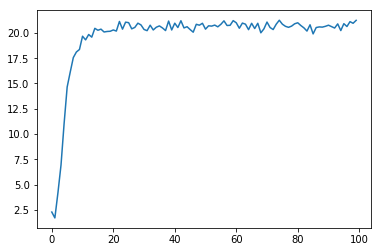

In [9]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)